# 三、图像分割

上节回顾：图像基本操作
- 图像上绘制线段/绘制矩形框
- 图像几何变换，旋转，平移，缩放等
- 高斯滤波/中值滤波
- 图像亮度变化，gamma变化，直方图均衡化
- 图像膨胀与腐蚀
- 图像开运算和闭运算

目录
1. 图像分割
2. 固定阈值法
3. 自动阈值法
4. 边缘检测
5. 连通区域分析
6. 区域生长算法
7. 分水岭算法

学习目标
- 掌握图像分割基本方法 —— 阈值法 ， 包括固定阈值， 大津阈值法和自适应阈值。
- 掌握图像边缘检测算子原理
- 掌握 Canny 边缘检测方法
- 学习连通区域分析，区域生长，分水岭等算法思想， 能使用算法实现图像分割



## 3.1 概念

图像分割是指将图像分成若干具有相似性质的区域的过程，主要有<u>**基于阈值**</u>、<u>**基于区域**</u>、<u>**基于边缘**</u>、<u>**基于聚类**</u>、<u>**<u>基于图论**</u>和<u>**基于深度学习**</u>的图像分割方法等。

图像分割分为<u>**语义分割**</u>和<u>**实例分割**</u>。

<center class="half">
    <img src="./assets/intro1.png"/>
    <img src="./assets/intro2.png"/>
</center>



分割的原则就是使划分后的子图在<u>内部保持相似度最大</u>，而<u>子图之间的相似度保持最小</u>。

将 $G = (V,E)$ 分成两个子集 $A$，$B$，使得 $A\cup B=V,\;A\cap B=\emptyset$

![intro3](assets/intro3.png)


## 3.2 固定阈值

直方图双峰法
- 双峰法：六十年代中期提出的直方图双峰法(也称 mode 法) 是典型的全局单阈值分割方法。
- 基本思想：假设图像中有明显的目标和背景，则其灰度直方图呈双峰分布，当灰度级直方图具有双峰特性时，<u>选取两峰之间的谷对应的灰度级作为阈值</u>。

![mode](assets/mode.png)

函数： `cv2.threshold(src, thresh, maxval, type)`

参数说明
- 参数1： 原图像
- 参数2： 对像素值进行分类的阈值
- 参数3： 当像素值高于(小于)阈值时，应该被赋予的新的像素值
- 参数4： 第四个参数是阈值方法。
- 返回值： 函数有两个返回值，一个为 `retVal`, 一个阈值化处理之后的图像。

![threshold](assets/fix_threshold.png)

In [3]:
#加载opencv和matplotlib
import cv2
import matplotlib.pyplot as plt

# 灰度图读入
img = cv2.imread('./image/thresh.png', 0)
threshold = 127
# 阈值分割
ret, th = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
print(ret)

cv2.imshow('thresh', th)
cv2.waitKey(0)
cv2.destroyAllWindows()

127.0


### 3.2.1 常用的阈值方法

- `THRESH_BINARY`：$\operatorname{det}(x, y)= \begin{cases}\text { maxval } & \text { if } \operatorname{src}(x, y)>\text { thresh } \\ 0 & \text { otherwise }\end{cases}$
- `THRESH_BINARY_INV`：$\operatorname{dst}(x, y)= \begin{cases}0 & \text { if } \operatorname{arc}(x, y)>\text { threshold } \\ \text { maxval } & \text { otherwise }\end{cases}$
- `THRESH_TRUNC`：$\operatorname{dst}(x, y)= \begin{cases}\operatorname{threshold} & \text { if } \operatorname{src}(x, y)>\operatorname{threshold} \\ \operatorname{src}(x, y) & \text { otherwise }\end{cases}$
- `THRESH_TOZERO`：$\operatorname{dst}(x, y)= \begin{cases}\operatorname{src}(x, y) & \text { if } \operatorname{src}(x, y)>\operatorname{threshold} \\ 0 & \text { otherwise }\end{cases}$
- `THRESH_TOZERO_INV`：$\operatorname{dst}[x, y)= \begin{cases}0 & \text { if } \operatorname{src}(x, y)>\text { threshold } \\ \operatorname{src}(x, y) & \text { otherwise }\end{cases}$

### 3.2.2 固定阈值不同方法比较

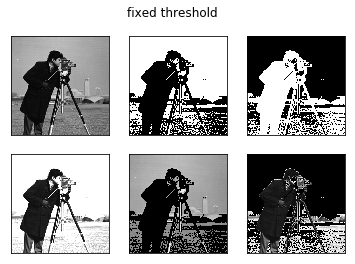

In [4]:
#导入第三方包
import cv2
from matplotlib import pyplot as plt

#opencv读取图像
img = cv2.imread('./image/person.png', 0)
#5种阈值法图像分割
ret, thresh1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
ret, thresh3 = cv2.threshold(img, 127, 255, cv2.THRESH_TRUNC)
ret, thresh4 = cv2.threshold(img, 127, 255, cv2.THRESH_TOZERO)
ret, thresh5 = cv2.threshold(img, 127, 255, cv2.THRESH_TOZERO_INV)

images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
#使用for循环进行遍历，matplotlib进行显示
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.suptitle('fixed threshold')
plt.show()

## 3.3 自动阈值

### 3.3.1 自适应阈值法

函数：`cv2.adaptiveThreshold()`

参数说明：

- 参数1：要处理的原图
- 参数2：最大阈值，一般为255
- 参数3：小区域阈值的计算方式
  - `ADAPTIVE_THRESH_MEAN_C`：小区域内取均值
  - `ADAPTIVE_THRESH_GAUSSIAN_C`：小区域内加权求和，权重是个高斯核
- 参数4：阈值方式（跟前面讲的那5种相同）
- 参数5：小区域的面积，如 11 就是 $11\times11$ 的小块
- 参数6：最终阈值等于小区域计算出的阈值再减去此值

特定： 自适应阈值会每次取图片的一小部分计算阈值，这样图片不同区域的阈值就不尽相同，适用于明暗分布不均的图片。

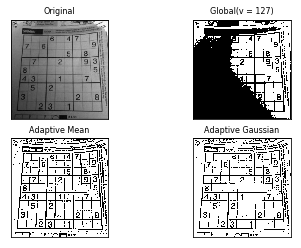

In [5]:
#自适应阈值与固定阈值对比
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('./image/paper2.png', 0)

# 固定阈值
ret, th1 = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
# 自适应阈值
th2 = cv2.adaptiveThreshold(
    img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 4)
th3 = cv2.adaptiveThreshold(
    img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 4)
#全局阈值，均值自适应，高斯加权自适应对比
titles = ['Original', 'Global(v = 127)', 'Adaptive Mean', 'Adaptive Gaussian']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2, 2, i + 1), plt.imshow(images[i], 'gray')
    plt.title(titles[i], fontsize=8)
    plt.xticks([]), plt.yticks([])
plt.show()

### 3.3.2 迭代法阈值

步骤

1. 求出图象的最大灰度值和最小灰度值，分别记为 $Z_{\max}$ 和 $Z_{\min}$，令初始阈值 $T_0=(Z_{\max}+Z_{\min})/2$；
2. 根据阈值 $T_K$ 将图象分割为前景和背景，分别求出两者的平均灰度值 $Z_O$ 和 $Z_B$ ；
3. 求出新阈值 $T_{K+1}=(Z_O+Z_B)/2$；
4. 若 $T_K==T_{K+1}$，则所得即为阈值；否则转 2，迭代计算；
5. 使用计算后的阈值进行固定阈值分割。

120.0


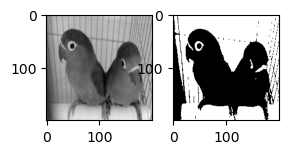

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


def best_thresh(img):
    img_array = np.array(img).astype(np.float32)  #转化成数组
    I = img_array
    zmax = np.max(I)
    zmin = np.min(I)
    tk = (zmax + zmin) / 2  #设置初始阈值
    #根据阈值将图像进行分割为前景和背景，分别求出两者的平均灰度zo和zb
    b = 1
    m, n = I.shape
    while b == 0:
        ifg = 0
        ibg = 0
        fnum = 0
        bnum = 0
        for i in range(1, m):
            for j in range(1, n):
                tmp = I(i, j)
                if tmp >= tk:
                    ifg = ifg + 1
                    fnum = fnum + int(tmp)  #前景像素的个数以及像素值的总和
                else:
                    ibg = ibg + 1
                    bnum = bnum + int(tmp)  #背景像素的个数以及像素值的总和
        #计算前景和背景的平均值
        zo = int(fnum / ifg)
        zb = int(bnum / ibg)
        if tk == int((zo + zb) / 2):
            b = 0
        else:
            tk = int((zo + zb) / 2)
    return tk


img = cv2.imread("./image/bird.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = cv2.resize(gray, (200, 200))  #大小
yvzhi = best_thresh(img)
ret1, th1 = cv2.threshold(img, yvzhi, 255, cv2.THRESH_BINARY)
print(ret1)
plt.figure(figsize=(3, 3))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(th1, cmap='gray')
plt.show()

### 3.3.3 Otsu大津法

大津法

- 最大类间方差法， 1979年日本学者大津提出，是一种基于<u>全局阈值</u>的自适应方法。
- 灰度特性：图像分为前景和背景。当取最佳阈值时，两部分之间的差别应该是最大的，衡量差别的标准为最大类间方差。
- 直方图有两个峰值的图像，大津法求得的Ｔ近似等于两个峰值之间的低谷。

![](assets/otsu.png)


$$
\begin{align}
\omega_1&=\frac{N_1}{M \times N} \\
\omega_2&=\frac{N_2}{M \times N} \\
N_1+N_2&=M \times N \\
\omega_1+\omega_2&=1 \\
\mu&=\mu_1 \times \omega_1+\mu_2 \times \omega_2 \\
g&=\omega_1 \times\left(\mu-\mu_1\right)^2+\omega_2 \times\left(\mu-\mu_2\right)^2
\end{align}
$$
得到等价公式
$$
g=\omega_1 \times \omega_2 \times\left(\mu_1-\mu_2\right)^2
$$

等价于最小类内方差 $\omega_1\sigma_1^2+\omega_2\sigma_2^2$

符号说明

- T：图像 $I(x,y)$ 前景和背景的分割阈值
- $\omega_1$：属于前景的像素点数占整幅图像的比例记，其平均灰度 $\mu_1$
- $\omega_2$：背景像素点数占整幅图像的比例为，其平均灰度为 $\mu_2$
- $\mu$：图像的总平均灰度
- $g$：类间方差
- $N_1$：设图像的大小为 $M\times N$，图像中像素的灰度值小于阈值 $T$ 的像素个数
- $N_2$：像素灰度大于阈值 $T$ 的像素个数
- $\sigma$：强度方差

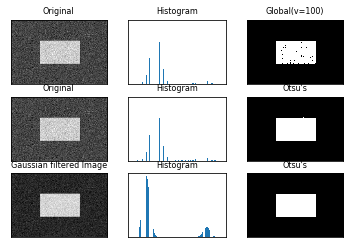

In [10]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('./image/noisy.png', 0)
# 固定阈值法
ret1, th1 = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
# Otsu阈值法
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 先进行高斯滤波，再使用Otsu阈值法
blur = cv2.GaussianBlur(img, (5, 5), 0)
ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
images = [img, 0, th1, img, 0, th2, blur, 0, th3]
titles = ['Original', 'Histogram', 'Global(v=100)',
          'Original', 'Histogram', "Otsu's",
          'Gaussian filtered Image', 'Histogram', "Otsu's"]

for i in range(3):
    # 绘制原图
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i * 3], 'gray')
    plt.title(titles[i * 3], fontsize=8)
    plt.xticks([]), plt.yticks([])

    # 绘制直方图plt.hist, ravel函数将数组降成一维
    plt.subplot(3, 3, i * 3 + 2)
    plt.hist(images[i * 3].ravel(), 256)
    plt.title(titles[i * 3 + 1], fontsize=8)
    plt.xticks([]), plt.yticks([])

    # 绘制阈值图
    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(images[i * 3 + 2], 'gray')
    plt.title(titles[i * 3 + 2], fontsize=8)
    plt.xticks([]), plt.yticks([])
plt.show()


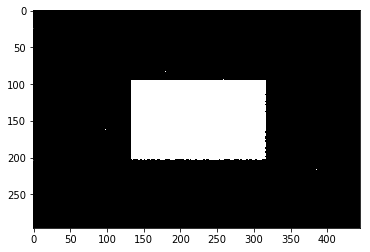

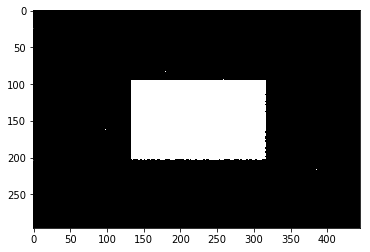

In [44]:
#Otsu源码
import numpy as np


def OTSU_enhance(img_gray, th_begin=0, th_end=256, th_step=1):
    #"must input a gary_img"
    assert img_gray.ndim == 2

    max_g = 0
    suitable_th = 0
    for threshold in range(th_begin, th_end, th_step):
        bin_img = img_gray > threshold
        bin_img_inv = img_gray <= threshold
        fore_pix = np.sum(bin_img)
        back_pix = np.sum(bin_img_inv)
        if 0 == fore_pix:
            break
        if 0 == back_pix:
            continue

        w0 = float(fore_pix) / img_gray.size
        u0 = float(np.sum(img_gray * bin_img)) / fore_pix
        w1 = float(back_pix) / img_gray.size
        u1 = float(np.sum(img_gray * bin_img_inv)) / back_pix
        # intra-class variance
        g = w0 * w1 * (u0 - u1) * (u0 - u1)
        if g > max_g:
            max_g = g
            suitable_th = threshold
    return suitable_th


img = cv2.imread('noisy.png', 0)
thresh = OTSU_enhance(img)
ret1, th1 = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)
ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
a = plt.imshow(th1, cmap=cm.gray)
plt.show(a)
b = plt.imshow(th2, cmap=cm.gray)
plt.show(b)

## 3.4 边缘提取（锐化）

### 3.4.1 图像梯度

梯度

- 梯度是一个向量，梯度方向指向函数变化最快的方向，大小就是它的模，也是最大的变化率，对于二元函数 $z=f(x,y)$，它在点 $(x,y)$ 的梯度就是 ${\rm grad}\,f(x,y)$ 或者 $\bigtriangledown f(x,y)$

$$
\text{grad }f(x,y)=\bigtriangledown f(x,y)=(\frac{\partial f}{\partial x},
\frac{\partial f}{\partial y})=
f_x(x,y){\overrightarrow i}+
f_y(x,y){\overrightarrow j}
$$

- 这个梯度向量的幅度和方向角为

$$
\text{mag}(\bigtriangledown f)=||\bigtriangledown f_{(2)}||=\sqrt{G_x^2+G_y^2}\\
\phi(x,y)=\arctan(\frac{G_y}{G_x})
$$

---

图像梯度

- 图像梯度即图像中灰度变化的度量，求图像梯度的过程是二维离散函数求导过程。边缘其实就是图像上灰度级变化很快的点的集合。
- 下表展示了一个灰度图的数学化表达，像素点 $(x,y)$ 的灰度值是 $f(x,y)$，它有八个邻域。

| $f(x-1,y+1)$ | $f(x,y+1)$ | $f(x+1,y+1)$ |
| ------------ | ---------- | ------------ |
| $f(x-1,y)$   | $f(x,y)$   | $f(x+1,y)$   |
| $f(x-1,y-1)$ | $f(x,y-1)$ | $f(x+1,y-1)$ |

- 图像在点 $(x,y)$ 的梯度为

$$
\begin{align}
G(x,y)&=(G_x,G_y)=\left(f_x(x,y),f_y(x,y)\right)\\
f_x(x,y)&=f(x+1,y)-f(x,y)\\
f_y(x,y)&=f(x,y+1)-f(x,y)
\end{align}
$$

- 其中 $f_x(x,y)$ 即 $g_x$ 对应图像的水平方向，
- $g_y(x,y)$ 即 $g_y$ 对应水图像的竖直方向。

---

一阶导

- 均匀变化的色块（梯度在缓慢变化）
- 剧烈变化的起始点
- 检测有无“边”产生

二阶导

- 均匀变化的始末位置
- 孤立点反应强烈
- 剧烈变化的始末位置
- 图像中突然明亮或者暗的点，捕捉细节较多

### 3.4.2 模板卷积

要理解梯度图的生成，就要先了解模板卷积的过程，模板卷积是模板运算的一种方式，其步骤如下

1. 将模板在输入图像中漫游，并将模板中心与图像中某个像素位置重合；
2. 将模板上各个系数与模板下各对应像素的灰度相乘；
3. 将所有乘积相加（为保持灰度范围，常将结果再除以模板系数之和，后面梯度算子模板和为 0 的话就不需要除了）；
4. 将上述运算结果（模板的响应输出）赋给输出图像中对应模板中心位置的像素。

![image-20220926214116847](https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220926214116847.png)

### 3.4.3 梯度图

梯度图的生成和模板卷积相同，不同的是要生成梯度图，还需要在模板卷积完成后计算在点 $(x,y)$ 梯度的<u>幅值</u>，将幅值作为像素值，这样才算完。

注意： 梯度图上每个像素点的灰度值就是梯度向量的幅度

生成梯度图需要模板，右图为水平和竖直方向最简单的模板。

水平方向：$g(x,y)=|G(x)|=|f(x+1,y)-f(x,y)|$

竖直方向：$g(x,y)=|G(y)|=|f(x,y+1)-f(x,y)|$

<center class="half">
    <img src="https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220926214345034.png" width="180"/>
    <img src="https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220926214349769.png" width="100"/>
    <p>最简单的水平、垂直梯度模板</p>
</center>


### 3.4.5 梯度算子

梯度算子：梯度算子是一阶导数算子，是水平 $G(x)$ 和竖直 $G(y)$ 方向对应模板的组合，也有对角线方向。

常见的一阶算子：Roberts交叉算子， Prewitt算子， Sobel算子

#### a. Roberts交叉算子

<img src="https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927114018655.png" alt="image-20220927114018655" style="zoom: 50%;" />

Roberts交叉算子其本质是一个对角线方向的梯度算子，对应的水平方向和竖直方向的梯度分别为
$$
G_x=f(x+1,y+1)-f(x,y)\\
G_y=f(x,y+1)-f(x+1,y)
$$
优点：边缘定位较准，适用于边缘明显且噪声较少的图像。

缺点：

- 没有描述水平和竖直方向的灰度变化，只关注了对角线方向，容易造成遗漏。
- 鲁棒性差。由于点本身参加了梯度计算，不能有效的抑制噪声的干扰。

#### b. Prewitt算子

<img src="https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927114133800.png" alt="image-20220927114133800" style="zoom:50%;" />

Prewitt算子是典型的 $3\times3$ 模板，其模板中心对应要求梯度的原图像坐标 $(x,y)$，$(x,y)$ 对应的 8-邻域的像素灰度值如下表所示：

| $f(x-1,y+1)$ | $f(x,y+1)$ | $f(x+1,y+1)$ |
| ------------ | ---------- | ------------ |
| $f(x-1,y)$   | $f(x,y)$   | $f(x+1,y)$   |
| $f(x-1,y-1)$ | $f(x,y-1)$ | $f(x+1,y-1)$ |

通过Prewitt算子的水平模板 $M(x)$ 卷积后，对应的水平方向梯度为

first differentiation in x, smoothing in y
$$
\begin{align}
G_x&=f(x+1,y+1)-f(x-1,y+1)\\
&+f(x+1,y)-f(x-1,y)\\
&+f(x+1,y-1)-f(x-1,y-1)
\end{align}
$$
通过Prewitt算子的竖直模板 $M(y)$ 卷积后，对应的竖直方向梯度为:
$$
\begin{align}
G_y&=f(x-1,y+1)-f(x-1,y-1)\\
&+f(x,y+1)-f(x,y-1)\\
&+f(x+1,y+1)-f(x+1,y-1)
\end{align}
$$
输出梯度图在 $(x,y)$ 的灰度值为:
$$
g(x,y)=\sqrt{G_x^2+G_y^2}
$$
Prewitt算子引入了类似局部平均的运算，对噪声具有平滑作用，较Roberts算子更能抑制噪声。

#### c. Sobel算子

![image-20220927114720199](https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927114720199.png)

Sobel算子其实就是是增加了权重系数的Prewitt算子，其模板中心对应要求梯度的原图像坐标，对应的8-邻域的像素灰度值如下表所示

| $f(x-1,y+1)$ | $f(x,y+1)$ | $f(x+1,y+1)$ |
| ------------ | ---------- | ------------ |
| $f(x-1,y)$   | $f(x,y)$   | $f(x+1,y)$   |
| $f(x-1,y-1)$ | $f(x,y-1)$ | $f(x+1,y-1)$ |

---

过Sobel算子的水平模板 $M_{x}$ 卷积后，对应的水平方向梯度为
$$
\begin{align}
G_x&=f(x+1,y+1)-f(x-1,y+1)\\
&+2f(x+1,y)-2f(x-1,y)\\
&+f(x+1,y-1)-f(x-1,y-1)
\end{align}
$$
通过Sobel算子的竖直模板 $M(y)$ 卷积后，对应的竖直方向梯度为

smoothing in x, first differentiation in y
$$
\begin{align}
G_y&=f(x-1,y+1)-f(x-1,y-1)\\
&+2f(x,y+1)-2f(x,y-1)\\
&+f(x+1,y+1)-f(x+1,y-1)
\end{align}
$$
输出梯度图在(x,y)的灰度值为
$$
g(x,y)=\sqrt{G_x^2+G_y^2}
$$
Sobel算子引入了类似局部加权平均的运算，对边缘的定位比要比Prewitt算子好。

---

函数：`dst = cv2.Sobel(src, ddepth, dx, dy, ksize)`

参数说明：

- 参数1：需要处理的图像；
- 参数2：图像的深度， -1 表示采用的是与原图像相同的深度。目标图像的深度必须大于等于原图像的深度；
- 参数3， 4： `dx` 和 `dy` 表示的是求导的阶数， 0 表示这个方向上没有求导，一般为0、 1、 2；
- 参数5：`ksize` 是Sobel算子的大小，必须为1、 3、 5、 7（奇数）。

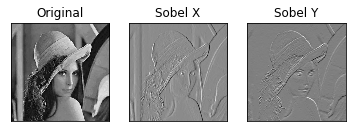

In [12]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('image/girl2.png', 0)
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)

plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 2), plt.imshow(sobelx, cmap='gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 3), plt.imshow(sobely, cmap='gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
plt.show()

## 3.5 Separable filter kernels

![image-20220929130123245](https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220929130123245.png)

允许计算效率更高的实现

![image-20220929130145992](https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220929130145992.png)

## 3.6 Canny边缘检测算法

Canny算子是先平滑后求导数的方法。 John Canny研究了最优边缘检测方法所需的特性，给出了评价边缘检测性能优劣的三个指标

1. 好的信噪比，即将非边缘点判定为边缘点的概率要低，将边缘点判为非边缘点的概率要低；
2. 高的定位性能，即检测出的边缘点要尽可能在实际边缘的中心；
3. 对单一边缘仅有唯一响应，即单个边缘产生多个响应的概率要低，并且虚假响应边缘应该得到最大抑制。

---

```py
cv2.Canny(image, th1, th2, Size)
```

- image：源图像
- th1：阈值1
- th2：阈值2
- Size：可选参数， Sobel算子的大小

步骤：

1. 彩色图像转换为灰度图像（以灰度图单通道图读入）
2. 对图像进行高斯模糊（去噪）
3. 计算图像梯度，根据梯度计算图像边缘幅值与角度
4. 沿梯度方向进行非极大值抑制（边缘细化）
5. 双阈值边缘连接处理
6. 二值化图像输出结果

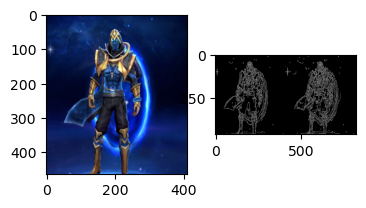

In [3]:
#加载opencv和numpy
import cv2
import numpy as np
import matplotlib.pyplot as plt

#以灰度图形式读入图像
img = cv2.imread('image/canny.png')
v1 = cv2.Canny(img, 80, 150, (3, 3))
v2 = cv2.Canny(img, 50, 100, (5, 5))

#np.vstack():在竖直方向上堆叠
#np.hstack():在水平方向上平铺堆叠
ret = np.hstack((v1, v2))

plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(ret,cv2.COLOR_BGR2RGB))
plt.show()

## 3.6 连通区域分析算法

连通区域（Connected Component）一般是指图像中具有相同像素值且位置相邻的前景像素点组成的图像区域，连通区域分析是指将图像中的各个连通区域找出并标记。

连通区域分析是一种在CV和图像分析处理的众多应用领域中较为常用和基本的方法。

例如： OCR识别中字符分割提取（车牌识别、文本识别、字幕识别等）、视觉跟踪中的运动前景目标分割与提取（行人入侵检测、遗留物体检测、基于视觉的车辆检测与跟踪等）、医学图像处理（感兴趣目标区域提取）等。

在需要将前景目标提取出来以便后续进行处理的应用场景中都能够用到连通区域分析方法，通常连通区域分析处理的对象是一张二值化后的图像。

---

连通区域概要

在图像中，最小的单位是像素，每个像素周围有邻接像素，常见的邻接关系有2种： 4邻接与8邻接。

<center class="half">
    <img src="https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927115926429.png" width="180"/>
    <img src="https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927115929622.png" width="180"/>
</center>


如果A与B连通， B与C连通，则A与C连通，在视觉上看来，彼此连通的点形成了一个区域，而不连通的点形成了不同的区域。这样的一个所有的点彼此连通点构成的集合，我们称为一个连通区域。

<center class="half">
    <img src="https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927120101819.png" width="350"/>
    <p>4邻接，则有3个连通区域</p>
    <p>8邻接，则有2个连通区域</p>
</center>


### 3.6.1 Two-Pass 算法

两遍扫描法（ Two-Pass ），正如其名，指的就是通过描两遍图像，将图像中存在的所有连通域找出并标记。

第一次扫描：

- 从左上角开始遍历像素点，找到第一个像素为 255 的点，`label=1`
- 当该像素的左邻像素和上邻像素为无效值时，给该像置一个新的 `label` 值，`label ++`，记录集合
- 当该像素的左邻像素或者上邻像素有一个为有效值时将有效值像素的 `label` 赋给该像素的 `label` 值
- 当该像素的左邻像素和上邻像素都为有效值时，选取其中较小的 `label` 值赋给该像素的 `label` 值

<center class="half">
    <img src="https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927120348211.png" width="250"/>
    <img src="https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927113034430.png" width="250"/>
</center>


第二次扫描：

- 对每个点的label进行更新，更新为其对于其集合中最小的label

<center class="half">
    <img src="https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927120530714.png" width="250"/>
    <img src="https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927120534347.png" width="250"/>
</center>


In [12]:
import cv2
import numpy as np

# 4邻域的连通域和 8邻域的连通域
# [row, col]
NEIGHBOR_HOODS_4 = True
OFFSETS_4 = [[0, -1], [-1, 0], [0, 0], [1, 0], [0, 1]]

NEIGHBOR_HOODS_8 = False
OFFSETS_8 = [[-1, -1], [0, -1], [1, -1],
             [-1, 0], [0, 0], [1, 0],
             [-1, 1], [0, 1], [1, 1]]


#第二遍扫描
def reorganize(binary_img: np.array):
    index_map = []
    points = []
    index = -1
    rows, cols = binary_img.shape
    for row in range(rows):
        for col in range(cols):
            var = binary_img[row][col]
            if var < 0.5:
                continue
            if var in index_map:
                index = index_map.index(var)
                num = index + 1
            else:
                index = len(index_map)
                num = index + 1
                index_map.append(var)
                points.append([])
            binary_img[row][col] = num
            points[index].append([row, col])
    #print(binary_img)
    #print(points)
    return binary_img, points


#四领域或八领域判断
def neighbor_value(binary_img: np.array, offsets, reverse=False):
    rows, cols = binary_img.shape
    label_idx = 0
    rows_ = [0, rows, 1] if reverse == False else [rows - 1, -1, -1]
    cols_ = [0, cols, 1] if reverse == False else [cols - 1, -1, -1]
    for row in range(rows_[0], rows_[1], rows_[2]):
        for col in range(cols_[0], cols_[1], cols_[2]):
            label = 256
            if binary_img[row][col] < 0.5:
                continue
            for offset in offsets:
                neighbor_row = min(max(0, row + offset[0]), rows - 1)
                neighbor_col = min(max(0, col + offset[1]), cols - 1)
                neighbor_val = binary_img[neighbor_row, neighbor_col]
                if neighbor_val < 0.5:
                    continue
                label = neighbor_val if neighbor_val < label else label
            if label == 255:
                label_idx += 1
                label = label_idx
            binary_img[row][col] = label
    print('第一遍扫描：', binary_img)
    print('开始第二遍...')
    return binary_img


# binary_img: bg-0, object-255; int
#第一遍扫描
def Two_Pass(binary_img: np.array, neighbor_hoods):
    if neighbor_hoods == NEIGHBOR_HOODS_4:
        offsets = OFFSETS_4
    elif neighbor_hoods == NEIGHBOR_HOODS_8:
        offsets = OFFSETS_8
    else:
        raise ValueError

    binary_img = neighbor_value(binary_img, offsets, False)

    return binary_img


if __name__ == "__main__":
    #创建四行七列的矩阵
    binary_img = np.zeros((4, 7), dtype=np.int16)
    #指定点设置为255
    index = [[0, 2], [0, 5],
             [1, 0], [1, 1], [1, 2], [1, 4], [1, 5], [1, 6],
             [2, 2], [2, 5],
             [3, 1], [3, 2], [3, 4], [3, 5], [3, 6]]
    for i in index:
        binary_img[i[0], i[1]] = np.int16(255)

    print("原始二值图像")
    print(binary_img)

    #print("Two_Pass")
    #调用Two Pass算法，计算第一遍扫面的结果
    binary_img = Two_Pass(binary_img, NEIGHBOR_HOODS_4)
    #print(binary_img)
    #计算第一遍扫面的结果
    binary_img, points = reorganize(binary_img)
    print(binary_img)
    #print(points)

原始二值图像
[[  0   0 255   0   0 255   0]
 [255 255 255   0 255 255 255]
 [  0   0 255   0   0 255   0]
 [  0 255 255   0 255 255 255]]
第一遍扫描： [[0 0 1 0 0 2 0]
 [3 3 1 0 4 2 2]
 [0 0 1 0 0 2 0]
 [0 5 1 0 6 2 2]]
开始第二遍...
[[0 0 1 0 0 2 0]
 [3 3 1 0 4 2 2]
 [0 0 1 0 0 2 0]
 [0 5 1 0 6 2 2]]



### 3.6.2 区域生长算法 DFS

算法概要

- 区域生长是一种串行区域分割的图像分割方法。区域生长是指从某个像素出发，按照一定的准则，逐步加入邻近像素，当满足一定的条件时，区域生长终止。

区域生长的好坏决定于

- 初始点（种子点）的选取。
- 生长准则。
- 终止条件。

区域生长是从某个或者某些像素点出发，最后得到整个区域，进而实现目标的提取。

---

原理

- 基本思想：将具有相似性质的像素集合起来构成区域。

步骤：

1. 对图像顺序（随机）扫描，找到第 1 个还没有归属的像素, 设该像素为 $(x_0, y_0)$
2. 以 $(x_0, y_0)$ 为中心, 考虑 $(x_0, y_0)$ 的4邻域像素 $(x, y)$ 如果 $(x_0, y_0)$ 满足生长准则，将 $(x, y)$ 与 $(x_0, y_0)$ 合并(在同一区域内)，同时将 $(x, y)$ 压入堆栈
3. 从堆栈中取出一个像素, 把它当作 $(x_0, y_0)$ 返回到步骤 2
4. 当堆栈为空时，返回到步骤 1
5. 重复步骤 1 - 4 直到图像中的每个点都有归属时
6. 生长结束。

![image-20220927120916606](https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927120916606.png)

In [17]:
# -*- coding:utf-8 -*-
import cv2
import numpy as np


####################################################################################


#######################################################################################
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def getX(self):
        return self.x

    def getY(self):
        return self.y


connects = [Point(-1, -1), Point(0, -1), Point(1, -1), Point(1, 0),
            Point(1, 1), Point(0, 1), Point(-1, 1), Point(-1, 0)]


#####################################################################################
#计算两个点间的欧式距离
def get_dist(seed_location1, seed_location2):
    l1 = im[seed_location1.x, seed_location1.y]
    l2 = im[seed_location2.x, seed_location2.y]
    count = np.sqrt(np.sum(np.square(l1 - l2)))
    return count


#import Image
im = cv2.imread('image/222.jpg')
cv2.imshow('src', im)
cv2.waitKey(0)
cv2.destroyAllWindows()
im_shape = im.shape
height = im_shape[0]
width = im_shape[1]

print('the shape of image :', im_shape)

#标记，判断种子是否已经生长
img_mark = np.zeros([height, width])
cv2.imshow('img_mark', img_mark)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 建立空的图像数组,作为一类
img_re = im.copy()
for i in range(height):
    for j in range(width):
        img_re[i, j][0] = 0
        img_re[i, j][1] = 0
        img_re[i, j][2] = 0
cv2.imshow('img_re', img_re)
cv2.waitKey(0)
cv2.destroyAllWindows()
#取一点作为种子点
seed_list = []
seed_list.append(Point(15, 15))
T = 7  #阈值
class_k = 1  #类别
#生长一个类
while (len(seed_list) > 0):
    seed_tmp = seed_list[0]
    #将以生长的点从一个类的种子点列表中删除
    seed_list.pop(0)

    img_mark[seed_tmp.x, seed_tmp.y] = class_k

    # 遍历8邻域
    for i in range(8):
        tmpX = seed_tmp.x + connects[i].x
        tmpY = seed_tmp.y + connects[i].y

        if (tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= width):
            continue
        dist = get_dist(seed_tmp, Point(tmpX, tmpY))
        #在种子集合中满足条件的点进行生长
        if (dist < T and img_mark[tmpX, tmpY] == 0):
            img_re[tmpX, tmpY][0] = im[tmpX, tmpY][0]
            img_re[tmpX, tmpY][1] = im[tmpX, tmpY][1]
            img_re[tmpX, tmpY][2] = im[tmpX, tmpY][2]
            img_mark[tmpX, tmpY] = class_k
            seed_list.append(Point(tmpX, tmpY))

########################################################################################

#输出图像
cv2.imshow('OUTIMAGE', img_re)
cv2.waitKey(0)
cv2.destroyAllWindows()

the shape of image : (399, 600, 3)


## 3.7 分水岭算法

任意的灰度图像可以被看做是地质学表面，高亮度的地方是山峰，低亮度的地方是山谷。

![image-20220927120939697](https://raw.githubusercontent.com/plum-Yin/clould_picgo/main/pic/image-20220927120939697.png)

算法概要

- 给每个孤立的山谷（局部最小值）不同颜色的水（标签），当水涨起来，根据周围的山峰（梯度），不同的山谷也就是不同的颜色会开始合并，要避免山谷合并，需要在水要合并的地方建立分水岭，直到所有山峰都被淹没，所创建的分水岭就是分割边界线，这个就是分水岭的原理。

---

算法步骤

1. 加载原始图像
2. 阔值分割，将图像分割为黑白两个部分
3. 对图像进行开运算，即先腐蚀在膨胀
4. 对开运算的结果再进行膨胀，得到大部分是真实背景的区域（远离目标的区域）
5. 通过距离变换 Distance Transform 获取前景区域
6. 背景区域 `sure_bg` 和前景区域 `sure_fg` 相减，得到即有前景又有背景的重合区域，即边界
7. 连通区域处理，标记边界区域
8. 得到分水岭算法结果

In [20]:
# import cv2
"""
完成分水岭算法步骤：
1、加载原始图像
2、阈值分割，将图像分割为黑白两个部分
3、对图像进行开运算，即先腐蚀在膨胀
4、对开运算的结果再进行 膨胀，得到大部分是背景的区域
5、通过距离变换 Distance Transform 获取前景区域
6、背景区域sure_bg 和前景区域sure_fg相减，得到即有前景又有背景的重合区域
7、连通区域处理
8、最后使用分水岭算法
"""

import cv2
import numpy as np

# Step1. 加载图像
img = cv2.imread('image/yezi.jpg')
cv2.imshow("img", img)
cv2.waitKey(0)
cv2.destroyAllWindows()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Step2.阈值分割，将图像分为黑白两部分
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# cv2.imshow("thresh", thresh)

# Step3. 对图像进行“开运算”，先腐蚀再膨胀
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
# cv2.imshow("opening", opening)

# Step4. 对“开运算”的结果进行膨胀，得到大部分都是背景的区域
sure_bg = cv2.dilate(opening, kernel, iterations=3)
cv2.imshow("sure_bg", sure_bg)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Step5.通过distanceTransform获取前景区域
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)  # DIST_L1 DIST_C只能 对应掩膜为3    DIST_L2 可以为3或者5
cv2.imshow("dist_transform", dist_transform)
cv2.waitKey(0)
cv2.destroyAllWindows()
print(dist_transform.max())
ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)

# Step6. sure_bg与sure_fg相减,得到既有前景又有背景的重合区域   #此区域和轮廓区域的关系未知
sure_fg = np.uint8(sure_fg)
unknow = cv2.subtract(sure_bg, sure_fg)
cv2.imshow("unknow", unknow)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Step7. 连通区域处理
ret, markers = cv2.connectedComponents(sure_fg, connectivity=8)  #对连通区域进行标号  序号为 0 - N-1
#print(markers)
print(ret)
markers = markers + 1  #OpenCV 分水岭算法对物体做的标注必须都 大于1 ，背景为标号 为0  因此对所有markers 加1  变成了  1  -  N
#去掉属于背景区域的部分（即让其变为0，成为背景）
# 此语句的Python语法 类似于if ，“unknow==255” 返回的是图像矩阵的真值表。
markers[unknow == 255] = 0

# Step8.分水岭算法
markers = cv2.watershed(img, markers)  #分水岭算法后，所有轮廓的像素点被标注为  -1 
#print(markers)

img[markers == -1] = [0, 0, 255]  # 标注为-1 的像素点标 红
cv2.imshow("dst", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


145.3628
2


## 3.8 Meanshift

传入图片，图片每个点看成数据，数据做聚类，分割就出来了

聚类算法一般 k-means，先验知识知道 k 值